In [145]:
import pandas as pd
import matplotlib.pyplot as plt

from river import ensemble
from river import compose
from river import preprocessing
from river import metrics
from river import tree

from pprint import pprint

from source.bank_dataset import BankDataset

In [146]:
# Creating a data frame
df = pd.read_csv("../datasets/bank-additional-full.csv", delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Predict with River classification models

#### Apply data transformations

In [147]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical_features = (feature for feature in df.columns if feature not in categorical_features + ['y'])

transform_pipeline = compose.Select(categorical_features[0])
for feature in categorical_features[1:]:
    transform_pipeline += compose.Select(feature)
transform_pipeline |= preprocessing.OneHotEncoder()

for feature in numerical_features:
    transform_pipeline += compose.Select(feature)
transform_pipeline |= preprocessing.MinMaxScaler()

bank_dataset = BankDataset()
for idx, (x, y) in enumerate(bank_dataset):
    print(f'Initial features: {x}\n')
    x = transform_pipeline.transform_one(x)
    print(f'Transformed features: {x}\n\n')
    if idx + 1 == 10:
        break

Initial features: {'age': 56, 'job': 'housemaid', 'marital': 'married', 'education': 'basic.4y', 'default': 'no', 'housing': 'no', 'loan': 'no', 'contact': 'telephone', 'month': 'may', 'day_of_week': 'mon', 'duration': 261, 'campaign': 1, 'pdays': 999, 'previous': 0, 'poutcome': 'nonexistent', 'emp.var.rate': 1.1, 'cons.price.idx': 93.994, 'cons.conf.idx': -36.4, 'euribor3m': 4.857, 'nr.employed': 5191.0}

Transformed features: {'nr.employed': 0.0, 'euribor3m': 0.0, 'cons.conf.idx': 0.0, 'cons.price.idx': 0.0, 'emp.var.rate': 0.0, 'previous': 0.0, 'pdays': 0.0, 'campaign': 0.0, 'duration': 0.0, 'age': 0.0, 'poutcome_nonexistent': 0.0, 'day_of_week_mon': 0.0, 'month_may': 0.0, 'contact_telephone': 0.0, 'loan_no': 0.0, 'housing_no': 0.0, 'default_no': 0.0, 'education_basic.4y': 0.0, 'marital_married': 0.0, 'job_housemaid': 0.0}


Initial features: {'age': 57, 'job': 'services', 'marital': 'married', 'education': 'high.school', 'default': 'unknown', 'housing': 'no', 'loan': 'no', 'contact

#### Predict with Adaptive Random Forest Classifier

In [148]:
def evaluate_model(model):
    acc_metric = metrics.Accuracy()
    # Weighted-average F1 score.
    # This works by computing the F1 score per class,
    # and then performs a global weighted average by using the support of each class.
    f1_metric = metrics.WeightedF1()

    acc_metrics = []
    f1_metrics = []
    target_mapping = {
        'yes': 1,
        'no': 0
    }
    for idx, (x, y_true) in enumerate(bank_dataset):
        y_true = target_mapping[y_true]

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y_true)

        # Update the error metric
        if y_pred is not None:
            acc_metric = acc_metric.update(y_true, y_pred)
            f1_metric = f1_metric.update(y_true, y_pred)
        if (idx + 1) % 1000 == 0:
            acc_metrics.append(acc_metric.get())
            f1_metrics.append(f1_metric.get())
            print(f'Index: {idx + 1}; {acc_metric}; {f1_metric}')

    print('\n\n\nDebug pipeline:\n' + model.debug_one(x))

    # Plot the Accuracy results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(acc_metrics, lw=3, color='#2ecc71', alpha=0.8, label='Accuracy')
    ax.set_title(acc_metric)

    # Plot the F1 results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(f1_metrics, lw=3, color='#e74c3c', alpha=0.8, label='F1')
    ax.set_title(f1_metric)

Index: 1000; Accuracy: 98.10%; WeightedF1: 97.16%
Index: 2000; Accuracy: 97.90%; WeightedF1: 96.86%
Index: 3000; Accuracy: 97.63%; WeightedF1: 96.46%
Index: 4000; Accuracy: 97.20%; WeightedF1: 95.84%
Index: 5000; Accuracy: 97.08%; WeightedF1: 95.66%
Index: 6000; Accuracy: 97.00%; WeightedF1: 95.54%
Index: 7000; Accuracy: 97.04%; WeightedF1: 95.60%
Index: 8000; Accuracy: 96.85%; WeightedF1: 95.32%
Index: 9000; Accuracy: 96.69%; WeightedF1: 95.08%
Index: 10000; Accuracy: 96.65%; WeightedF1: 95.03%
Index: 11000; Accuracy: 96.59%; WeightedF1: 94.95%
Index: 12000; Accuracy: 96.49%; WeightedF1: 94.83%
Index: 13000; Accuracy: 96.38%; WeightedF1: 94.66%
Index: 14000; Accuracy: 96.20%; WeightedF1: 94.41%
Index: 15000; Accuracy: 96.00%; WeightedF1: 94.11%
Index: 16000; Accuracy: 95.76%; WeightedF1: 93.75%
Index: 17000; Accuracy: 95.69%; WeightedF1: 93.64%
Index: 18000; Accuracy: 95.60%; WeightedF1: 93.51%
Index: 19000; Accuracy: 95.61%; WeightedF1: 93.52%
Index: 20000; Accuracy: 95.45%; Weighted

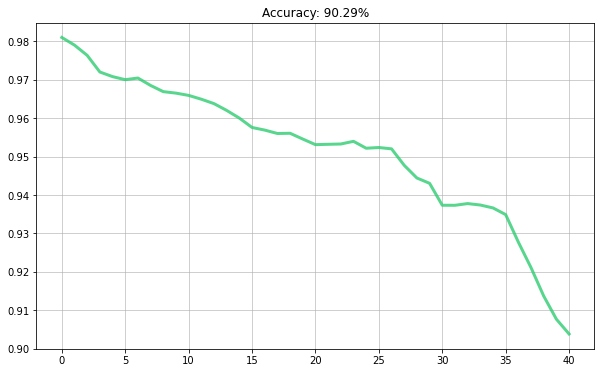

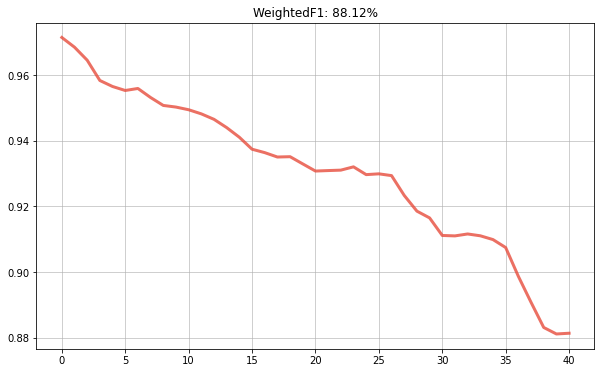

In [143]:
ARF_model = transform_pipeline | ensemble.AdaptiveRandomForestClassifier(seed=42, leaf_prediction="mc")
evaluate_model(ARF_model)

#### Predict with Streaming Random Patches ensemble classifier

Index: 1000; Accuracy: 98.00%; WeightedF1: 97.65%
Index: 2000; Accuracy: 97.70%; WeightedF1: 97.30%
Index: 3000; Accuracy: 97.40%; WeightedF1: 96.75%
Index: 4000; Accuracy: 96.95%; WeightedF1: 96.23%
Index: 5000; Accuracy: 96.82%; WeightedF1: 96.06%
Index: 6000; Accuracy: 96.75%; WeightedF1: 95.92%
Index: 7000; Accuracy: 96.79%; WeightedF1: 95.95%
Index: 8000; Accuracy: 96.59%; WeightedF1: 95.72%
Index: 9000; Accuracy: 96.46%; WeightedF1: 95.67%
Index: 10000; Accuracy: 96.40%; WeightedF1: 95.63%
Index: 11000; Accuracy: 96.35%; WeightedF1: 95.62%
Index: 12000; Accuracy: 96.33%; WeightedF1: 95.64%
Index: 13000; Accuracy: 96.17%; WeightedF1: 95.44%
Index: 14000; Accuracy: 96.08%; WeightedF1: 95.43%
Index: 15000; Accuracy: 95.87%; WeightedF1: 95.24%
Index: 16000; Accuracy: 95.61%; WeightedF1: 94.99%
Index: 17000; Accuracy: 95.52%; WeightedF1: 94.93%
Index: 18000; Accuracy: 95.48%; WeightedF1: 94.90%
Index: 19000; Accuracy: 95.51%; WeightedF1: 94.92%
Index: 20000; Accuracy: 95.44%; Weighted

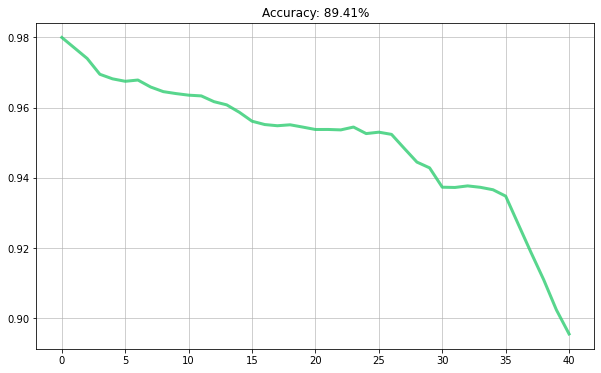

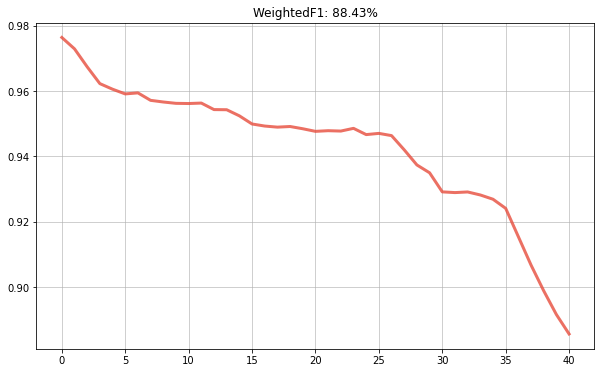

In [149]:
base_model = tree.HoeffdingTreeClassifier(
     grace_period=50, delta=0.01
)
SRP_model_obj = ensemble.SRPClassifier(
     model=base_model, n_models=3, seed=42
)
SRP_model = transform_pipeline | SRP_model_obj
evaluate_model(SRP_model)